<a href="https://colab.research.google.com/github/pradyutsingh/semantic_segmentation/blob/master/semantic_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from __future__ import division
import numpy as np 
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.models import load_model

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_path = "/content/drive/My Drive/cityscapes_data/train"
validation_path = "/content/drive/My Drive/cityscapes_data/val"

In [0]:
#now lets load the images
def loadimage(name,path= train_path,size = (256,200), rotation=0.0,flip=False,cut_bottom=58):
    

    img = Image.open(path + "/" + name)
    img = np.array(img)
    # now we are the cutting the images into 2 parts/ one is the original image and one is the segmented image
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]

    for i in range(3):
        img1 = img[:,:,i]
        img1 = cv2.equalizeHist(img1)
        img[:,:,i]=img1
    

    #resizing the image
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)

    img=img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:

        img = img[:,::-1,:]
        seg = seg[:,::-1,:] 
    
    img = np.true_divide(img, 255)
    seg = np.true_divide(seg, 255)
    
    return img,seg
    

    

In [9]:
#now to find the most important colors and identify similar colors we will
#use k-means clustering algorithm
#we are going to use 13 clusters of colors to identify similar colors

files = os.listdir(train_path)[0:10]
colors = []

for file in files:
    img,seg = loadimage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1],3))

colors= np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

kmeans = KMeans(13)
kmeans.fit(colors)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [10]:
print(colors)

[[0.         0.02745098 0.00392157]
 [0.03529412 0.08235294 0.04313725]
 [0.         0.03137255 0.        ]
 ...
 [0.48235294 0.25882353 0.4745098 ]
 [0.48235294 0.27058824 0.4745098 ]
 [0.2627451  0.05098039 0.25490196]]


In [0]:

def layerToColors(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    ximg = np.zeros((img.shape[0],img.shape[1],3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]

        for j in range(3):
            ximg[:,:,j] +=col[j]*c

    ximg = ximg/255
    return ximg  


    

In [0]:
#now this function converts the output of the kmeans clustering to 13-dimensional class representation
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = kmeans.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(kmeans.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

<function matplotlib.pyplot.show>

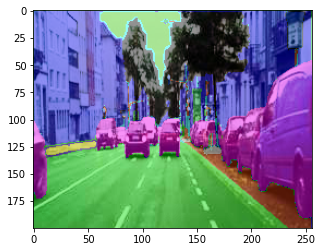

In [13]:
img,seg= loadimage("123.jpg")
seg2 = ColorsToClass(seg)
seg2 = layerToColors(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show


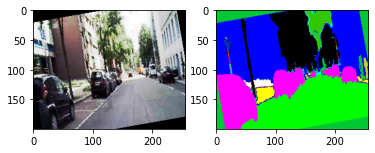

In [14]:

def Generate(path=train_path, batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = loadimage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(layerToColors(segs[0]))
plot.show()

In [18]:
#now we are gonna use the unet architecture to implement semantic segmentation
input = tf.keras.Input(shape=(200, 256, 3))

x1 = layers.BatchNormalization()(input)
x1 = layers.Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = layers.Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = layers.MaxPool2D()(x1)



x2 = layers.Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = layers.Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = layers.MaxPool2D()(x2)



x3 = layers.Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = layers.Conv2D(128, 6, activation="relu", padding="same")(x3)

p3 = layers.MaxPool2D()(x3)



x4 = layers.Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = layers.Conv2D(128, 3, activation="relu", padding="same")(x4)

x5 = layers.UpSampling2D()(x4)
x5 = layers.concatenate([x3, x5])
x5 = layers.Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = layers.Conv2D(128, 6, activation="relu", padding="same")(x5)


x6 = layers.UpSampling2D()(x5)
x6 = layers.concatenate([x2, x6])
x6 = layers.Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = layers.Conv2D(128, 6, activation="relu", padding="same")(x6)


x7 = layers.UpSampling2D()(x6)
x7 = layers.concatenate([x1, x7])
x7 = layers.Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = layers.Conv2D(13, 6, activation="softmax", padding="same")(x7)



model = tf.keras.Model(input, x7)

opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 256, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 256, 64) 27712       batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 256, 128 1179776     conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
train_gen = Generate()
val_gen = Generate(validation_path)

In [22]:
clb = [ModelCheckpoint("/content/drive/My Drive/loss.h5", save_best_only=True, verbose=0)]

h = model.fit(train_gen, epochs=100, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/100
10/10 - 24s - loss: 0.8673 - accuracy: 0.5625 - val_loss: 1.0109 - val_accuracy: 0.5299
Epoch 2/100
10/10 - 18s - loss: 0.9442 - accuracy: 0.5625 - val_loss: 1.1111 - val_accuracy: 0.5400
Epoch 3/100
10/10 - 17s - loss: 0.9099 - accuracy: 0.5643 - val_loss: 0.9596 - val_accuracy: 0.5402
Epoch 4/100
10/10 - 16s - loss: 0.9626 - accuracy: 0.5529 - val_loss: 0.9698 - val_accuracy: 0.5534
Epoch 5/100
10/10 - 16s - loss: 0.8910 - accuracy: 0.5559 - val_loss: 0.9461 - val_accuracy: 0.5118
Epoch 6/100
10/10 - 17s - loss: 0.8820 - accuracy: 0.5597 - val_loss: 0.9519 - val_accuracy: 0.5677
Epoch 7/100
10/10 - 20s - loss: 0.8785 - accuracy: 0.5498 - val_loss: 0.8921 - val_accuracy: 0.5493
Epoch 8/100
10/10 - 15s - loss: 0.8514 - accuracy: 0.5780 - val_loss: 0.9285 - val_accuracy: 0.5384
Epoch 9/100
10/10 - 16s - loss: 0.8486 - accuracy: 0.5528 - val_loss: 0.8872 - val_accuracy: 0.5454
Epoch 10

In [0]:
model.save("/content/drive/My Drive/model.h5")
model = tf.keras.models.load_model("/content/drive/My Drive/loss.h5")

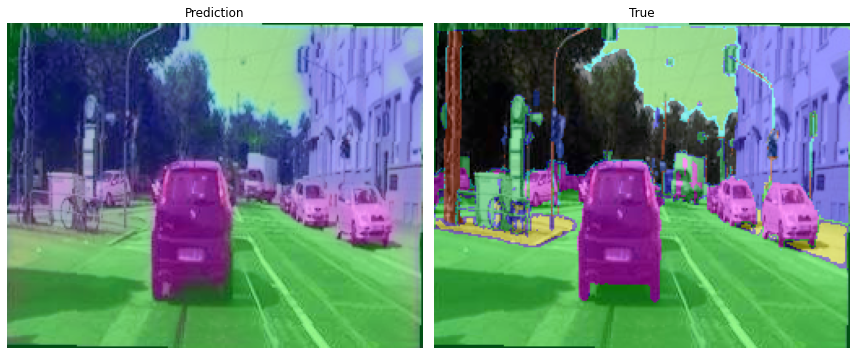

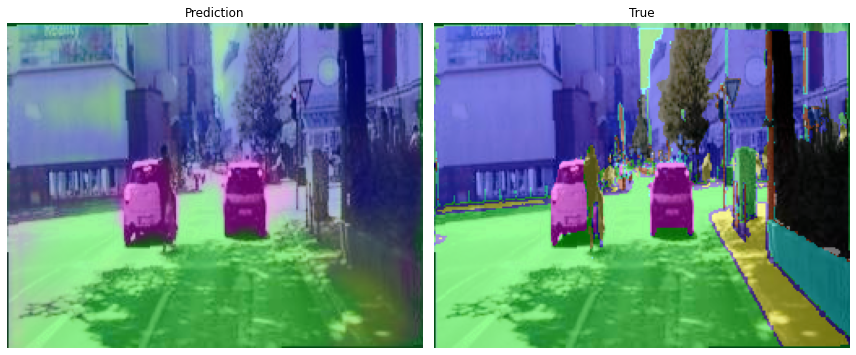

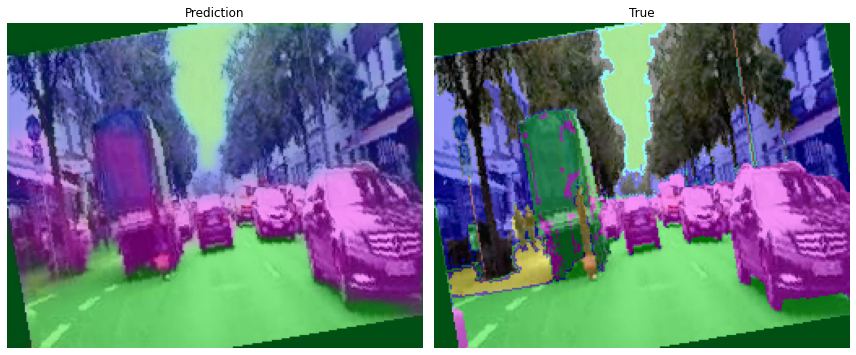

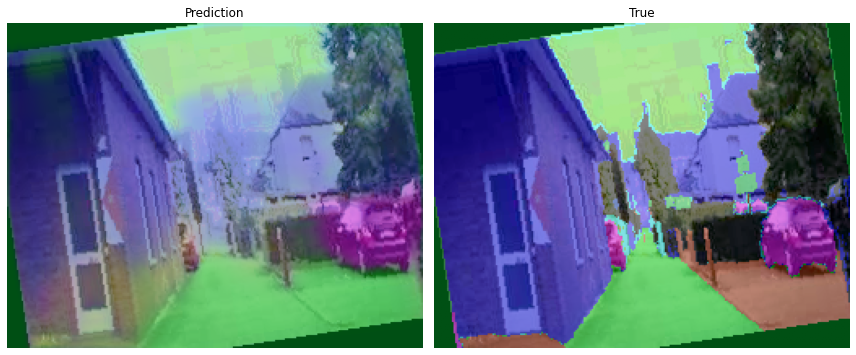

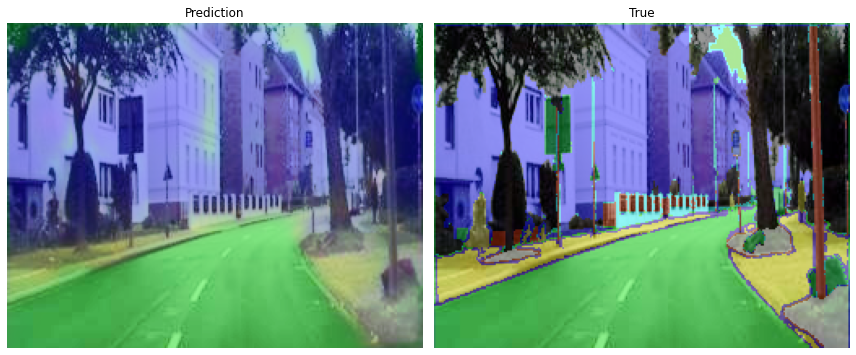

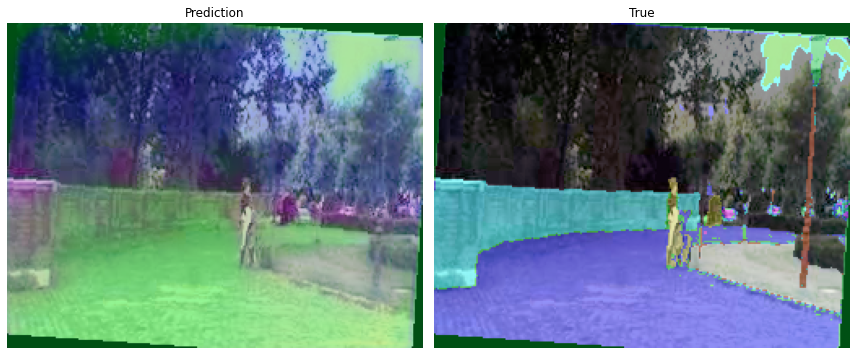

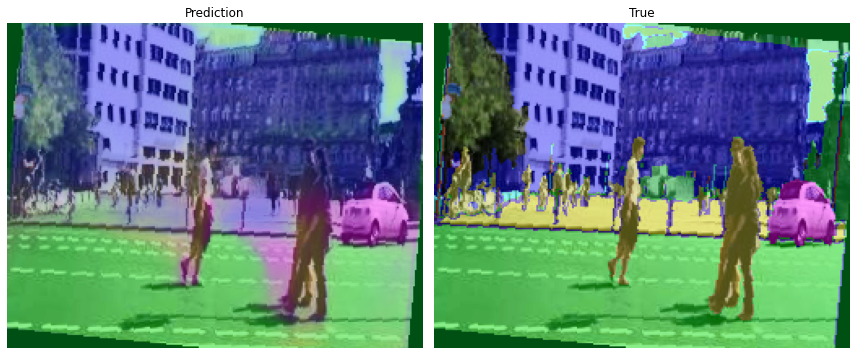

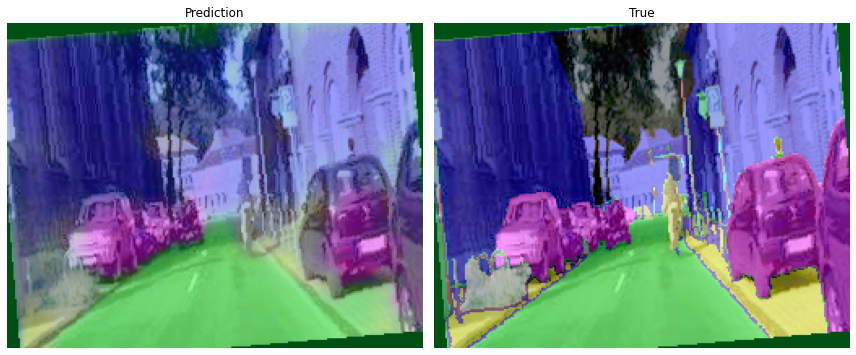

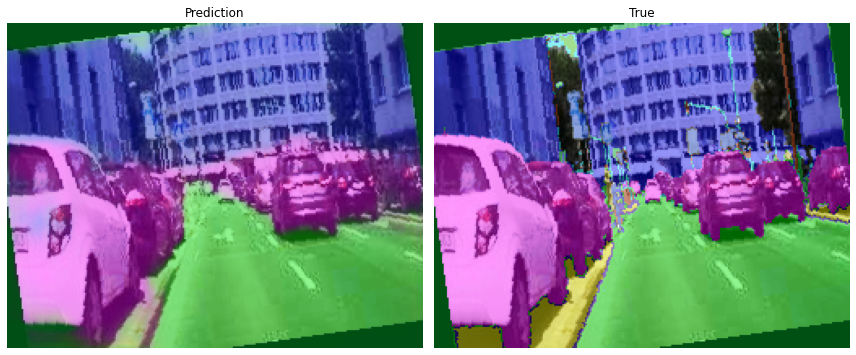

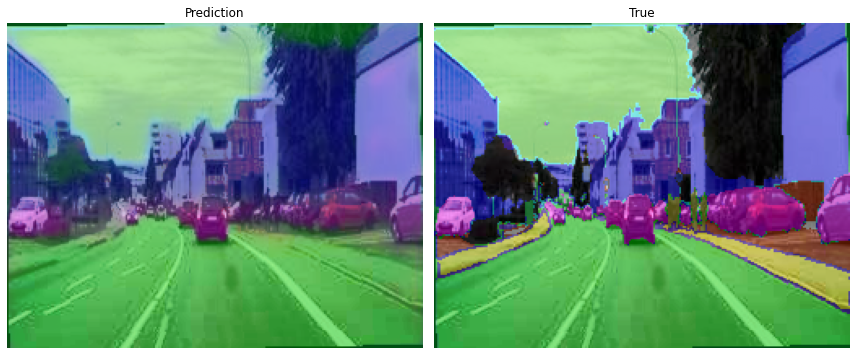

In [30]:
test_gen = Generate(validation_path)
max_show=20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = layerToColors(p[i])
        _s = layerToColors(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break